In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = 'Data' #modify path of file directory as appropriate
items = os.listdir(path)
list_of_paths = []

for a in items:
    list_of_paths.append(path + '/' + a)

In [3]:
def process(path): 
    """Processes path into dataframe"""
    ld = pd.read_csv(path)
    df = ld.iloc[:,:3]
    old_column = ld.columns[:3]

    df = df.rename(columns = {old_column[0]:'datetime', old_column[1]:'water_level', old_column[2]: 'is_high_tide'})
    
    df['river'] = path.split('/')[1].split('.')[0]
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['water_level'] = pd.to_numeric(df['water_level'], errors= 'ignore').astype(float)
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    return df

def pd_analyse_water_levels(path):
    """This function takes in the file path of a csv
    perfoms analysis with pandas
    Columns in the csv are Date and time, water_levels, 
    flag which is a categorical variable 1 or 0
    """

    df = process(path)

    df_high_tide = df[df["is_high_tide"] == 1]['water_level']
    df_low_tide = df[df["is_high_tide"] == 0]['water_level']
    summary_statistics = {'tide_high': {'mean':round(df_high_tide.mean(),2), 
                'median':round(df_high_tide.median(),2), 
                'interquartile_range':round((df_high_tide.quantile(.75) - df_high_tide.quantile(.25)),2)},
    'tide_low': {'mean':round(df_low_tide.mean()), 
                'median':round(df_low_tide.median(),2), 
                'interquartile_range':round((df_low_tide.quantile(.75) - df_low_tide.quantile(.25)),2)}}

    # Calculate ratio of high tide days
    all_high_days = df.query('is_high_tide==1').groupby('year').count()['water_level']
    high_days = df.query(f'(water_level>{df_high_tide.quantile(.75)}) & (is_high_tide==1)').groupby('year').count()['water_level']
    high_ratio = (high_days/all_high_days).reset_index()

    # Calculate ratio of low tide days
    all_low_days = df.query('is_high_tide==0').groupby('year').count()['water_level']
    low_days = df.query(f'(water_level<{df_low_tide.quantile(.25)}) & (is_high_tide==0)').groupby('year').count()['water_level']
    low_ratio = (low_days/all_low_days).reset_index()

    solution = {'river': path.split('/')[1].split('.')[0],'summary_statistics':summary_statistics, 'high_ratio': high_ratio, 'low_ratio':low_ratio}
    new = high_ratio.join(low_ratio, lsuffix = '_low_ratio')
    new.to_excel('{}_levels.xlsx'.format(path.split('/')[1].split('.')[0]))
    print(solution)
    

In [4]:
#for path in list_of_paths:
    #pd_analyse_water_levels(path)

MAKE INTO TIMESERIES FORECASTING

In [5]:
#list_of_df = []

#for path in list_of_paths:
    #list_of_df.append(process(path))
    #river_df = pd.concat(list_of_df,axis = 0)

#river_df

In [6]:
#london_bridge_df = process(list_of_paths[0])
#london_bridge_df

In [7]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType,StringType
from pyspark.sql.window import Window

In [8]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(list_of_paths[0], header = True)

new_columns = ['datetime', "water_level","is_high_tide", "not_needed"]
for col,new in zip(df.columns,new_columns):  
    df = df.withColumn(new, df[col])
    df = df.drop(col)
    df = df.drop("not_needed")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/18 05:29:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
df.show()

+-------------------+-----------+------------+
|           datetime|water_level|is_high_tide|
+-------------------+-----------+------------+
|01/05/1911 15:40:00|     3.7130|           1|
|02/05/1911 11:25:00|    -2.9415|           0|
|02/05/1911 16:05:00|     3.3828|           1|
|03/05/1911 11:50:00|    -2.6367|           0|
|03/05/1911 16:55:00|     2.9256|           1|
|04/05/1911 12:10:00|    -2.4843|           0|
|04/05/1911 17:45:00|     3.1542|           1|
|05/05/1911 06:30:00|     3.0780|           1|
|05/05/1911 13:00:00|    -2.4843|           0|
|06/05/1911 07:35:00|     2.7732|           1|
|06/05/1911 14:25:00|    -1.9509|           0|
|07/05/1911 09:10:00|     2.6208|           1|
|07/05/1911 15:30:00|    -2.0271|           0|
|08/05/1911 10:25:00|     2.6716|           1|
|08/05/1911 16:50:00|    -2.1033|           0|
|09/05/1911 12:00:00|     3.0018|           1|
|09/05/1911 18:05:00|    -2.2303|           0|
|10/05/1911 07:00:00|    -2.6367|           0|
|10/05/1911 1

In [10]:
df = df.withColumn("Date", F.split('datetime', " ").getItem(0))
df = df.withColumn("Timeofday", F.split('datetime', " ").getItem(1))
df = df.withColumn("Timeofday", F.split('Timeofday', ":").getItem(0))
df = df.withColumn("Timeofday", F.when(df['Timeofday']>= 12, 1)\
                                .when(df['Timeofday']< 12,0))

#Timeofday corresponds to when reading was taken - Afternoon :1, morning : 0
#df = df.drop("datetime")
df.show()

+-------------------+-----------+------------+----------+---------+
|           datetime|water_level|is_high_tide|      Date|Timeofday|
+-------------------+-----------+------------+----------+---------+
|01/05/1911 15:40:00|     3.7130|           1|01/05/1911|        1|
|02/05/1911 11:25:00|    -2.9415|           0|02/05/1911|        0|
|02/05/1911 16:05:00|     3.3828|           1|02/05/1911|        1|
|03/05/1911 11:50:00|    -2.6367|           0|03/05/1911|        0|
|03/05/1911 16:55:00|     2.9256|           1|03/05/1911|        1|
|04/05/1911 12:10:00|    -2.4843|           0|04/05/1911|        1|
|04/05/1911 17:45:00|     3.1542|           1|04/05/1911|        1|
|05/05/1911 06:30:00|     3.0780|           1|05/05/1911|        0|
|05/05/1911 13:00:00|    -2.4843|           0|05/05/1911|        1|
|06/05/1911 07:35:00|     2.7732|           1|06/05/1911|        0|
|06/05/1911 14:25:00|    -1.9509|           0|06/05/1911|        1|
|07/05/1911 09:10:00|     2.6208|           1|07

In [11]:
def conv_season(a:int):
    month_to_season = {1:'winter',2:'winter', 3:'spring', 4: 'spring', 5:'spring', 
    6:'summer', 7:'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 11:'autumn',
    12:'winter' }
    return month_to_season[a]

In [12]:
season_udf = F.udf(conv_season, StringType())

df = df.withColumn('Date', F.to_date(df['Date'], "dd/MM/yyyy"))\
    .withColumn('year', F.split("Date", "-").getItem(0).cast(IntegerType()))\
    .withColumn('month', F.split('Date', '-').getItem(1).cast(IntegerType()))\
    .withColumn('water_level', df['water_level'].cast(FloatType()))\
    .withColumn('is_high_tide', df['is_high_tide'].cast(IntegerType()))\
    .withColumn('Timeofday', df['Timeofday'].cast(IntegerType()))
    
df = df.withColumn('season', season_udf(df['month']))
df.show()

#Handle month due to numbers as algorithm will malfunction based on this 
#Add other rivers, because there may be relationship between river levels
#Convert season into categorical variables
#modularise for others

+-------------------+-----------+------------+----------+---------+----+-----+------+
|           datetime|water_level|is_high_tide|      Date|Timeofday|year|month|season|
+-------------------+-----------+------------+----------+---------+----+-----+------+
|01/05/1911 15:40:00|      3.713|           1|1911-05-01|        1|1911|    5|spring|
|02/05/1911 11:25:00|    -2.9415|           0|1911-05-02|        0|1911|    5|spring|
|02/05/1911 16:05:00|     3.3828|           1|1911-05-02|        1|1911|    5|spring|
|03/05/1911 11:50:00|    -2.6367|           0|1911-05-03|        0|1911|    5|spring|
|03/05/1911 16:55:00|     2.9256|           1|1911-05-03|        1|1911|    5|spring|
|04/05/1911 12:10:00|    -2.4843|           0|1911-05-04|        1|1911|    5|spring|
|04/05/1911 17:45:00|     3.1542|           1|1911-05-04|        1|1911|    5|spring|
|05/05/1911 06:30:00|      3.078|           1|1911-05-05|        0|1911|    5|spring|
|05/05/1911 13:00:00|    -2.4843|           0|1911-05-

In [13]:
df = df.withColumn('row_number', F.monotonically_increasing_id())

w = Window().orderBy(df['row_number'])

df = df.withColumn('previous_water_level', F.lag('water_level', offset= 1).over(w))
df = df.withColumn('difference', F.col('water_level') - F.col('previous_water_level'))

#dropping first null entry
df = df.dropna()
df.show()

23/01/18 05:29:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:29:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:29:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/18 05:29:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:29:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------------------+-----------+------------+----------+---------+----+-----+------+----------+--------------------+-----------+
|           datetime|water_level|is_high_tide|      Date|Timeofday|year|month|season|row_number|previous_water_level| difference|
+-------------------+-----------+------------+----------+---------+----+-----+------+----------+--------------------+-----------+
|02/05/1911 11:25:00|    -2.9415|           0|1911-05-02|        0|1911|    5|spring|         1|               3.713|    -6.6545|
|02/05/1911 16:05:00|     3.3828|           1|1911-05-02|        1|1911|    5|spring|         2|             -2.9415|     6.3243|
|03/05/1911 11:50:00

23/01/18 05:30:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:30:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:30:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/18 05:30:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:30:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_5626/397725377.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['water_level'], ax = ax[1])


<AxesSubplot: xlabel='water_level', ylabel='Density'>

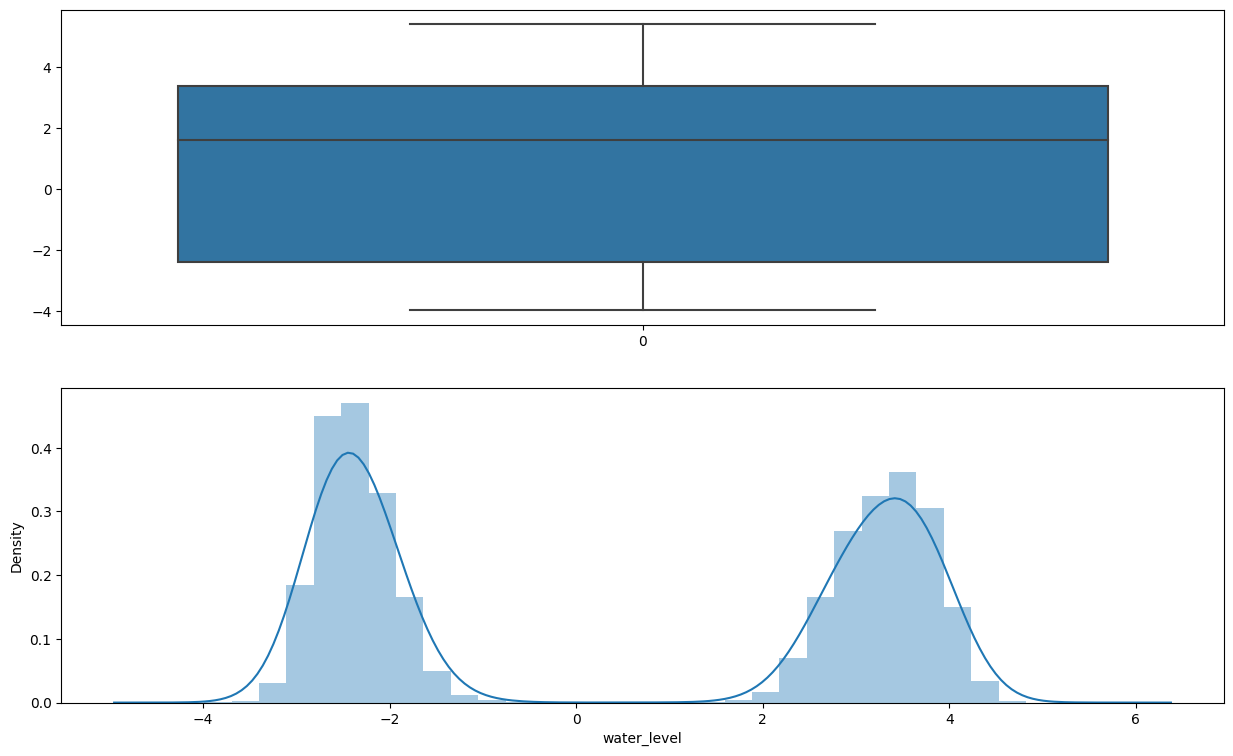

In [14]:
temp = df.sample(False, 0.5, 42).toPandas()
fig,ax = plt.subplots(2,1,figsize = (15,9))

sns.boxplot(temp['water_level'], ax = ax[0])
sns.distplot(temp['water_level'], ax = ax[1])

There are two normal distributions of water levels, which means this distribution can be split into two.

In [ ]:
print("The max year is {} while the minimum year is {}".format(df.agg({'year': 'max'}).collect()[0],df.agg({'year': 'min'}).collect()[0]))

In [19]:
high_tide_df = df.filter(df['is_high_tide'] == 0)
low_tide_df = df.filter(df['is_high_t'] == 1)
high_tide_df.show()

23/01/18 05:33:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/18 05:33:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------------------+-----------+------------+----------+---------+----+-----+------+----------+--------------------+-----------+
|           datetime|water_level|is_high_tide|      Date|Timeofday|year|month|season|row_number|previous_water_level| difference|
+-------------------+-----------+------------+----------+---------+----+-----+------+----------+--------------------+-----------+
|02/05/1911 11:25:00|    -2.9415|           0|1911-05-02|        0|1911|    5|spring|         1|               3.713|    -6.6545|
|03/05/1911 11:50:00|    -2.6367|           0|1911-05-03|        0|1911|    5|spring|         3|              3.3828|    -6.0195|
|05/05/1911 06:30:00

In [20]:
w = Window().orderBy(df['row_number'])

morning_levels_df = morning_levels_df.withColumn('morning_level_difference', F.col('water_level') -  F.lag('water_level', offset= 1).over(w))
morning_levels_df.show(50)

23/01/18 05:33:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 0

In [25]:
afternoon_levels_df = afternoon_levels_df.withColumn('afternoon_level_difference', F.col('water_level') -  F.lag('water_level', offset= 1).over(w))
afternoon_levels_df.show(20)

23/01/18 05:40:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/18 05:40:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:40:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------------------+-----------+------------+----------+---------+----+-----+------+----------+--------------------+----------+--------------------------+
|           datetime|water_level|is_high_tide|      Date|Timeofday|year|month|season|row_number|previous_water_level|difference|afternoon_level_difference|
+-------------------+-------

23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/18 05:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<AxesSubplot: xlabel='water_level', ylabel='morning_level_difference'>

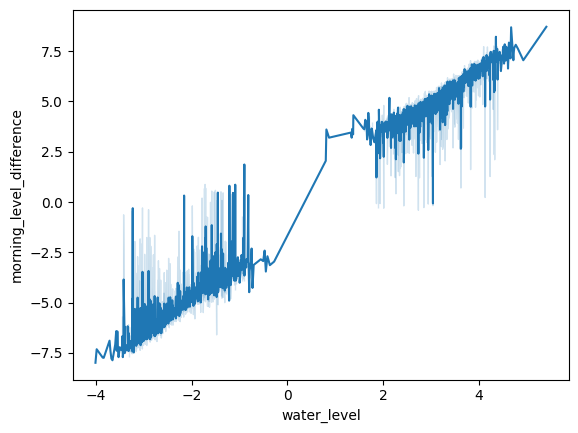

In [21]:
temp = morning_levels_df.sample(False, 0.5, 42).toPandas()

#sns.lineplot(data = temp, y ="water_level", x = "year")
#fig,ax = plt.subplots(3,2, figsize = (10,8))
#ax[0].set_title("Morning levels chart: water_level vs year")

sns.lineplot(data = temp, x = 'water_level',y = 'morning_level_difference')

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_5626/2055196143.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['water_level'], ax = ax[1])


<AxesSubplot: xlabel='water_level', ylabel='Density'>

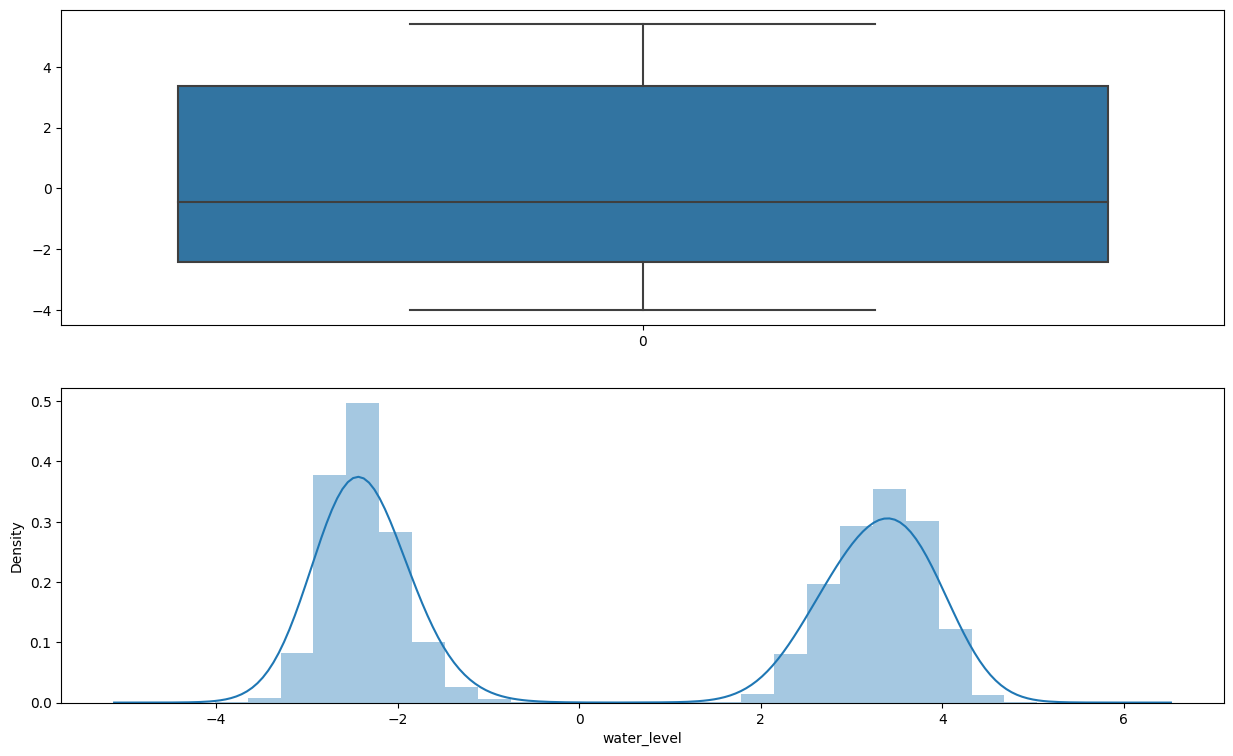

In [24]:
fig,ax = plt.subplots(2,1,figsize = (15,9))

sns.boxplot(temp['water_level'], ax = ax[0])
sns.distplot(temp['water_level'], ax = ax[1])

Since water levels distribution still has two normal distributions, rejoin the morning and afternoon levels dataframe 

<AxesSubplot: xlabel='month', ylabel='water_level'>

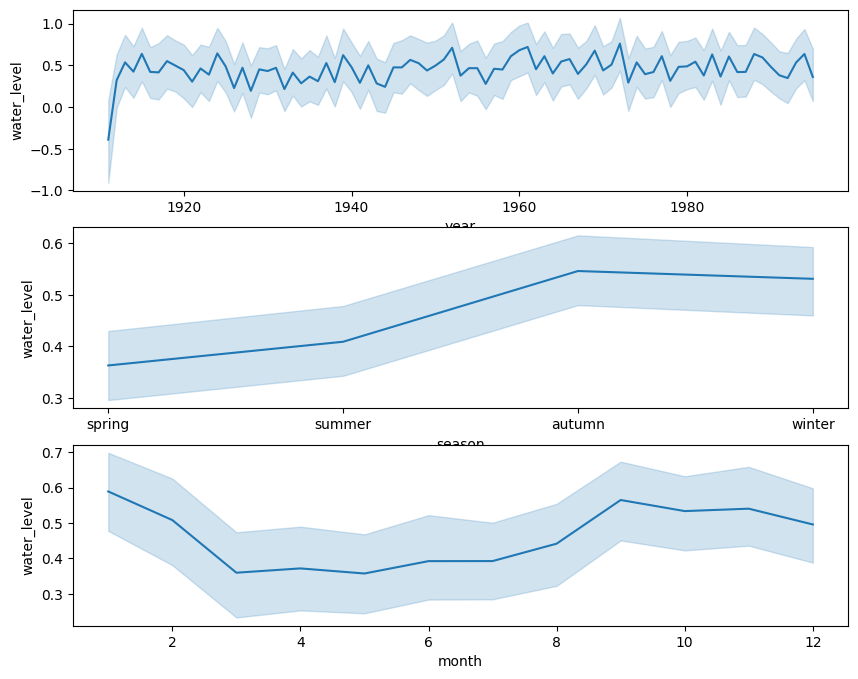

In [22]:
fig,ax = plt.subplots(3,1, figsize = (10,8))

sns.lineplot(data = temp, y = 'water_level', x  = 'year', ax = ax[0])
sns.lineplot(data = temp, y = 'water_level', x  = 'season', ax = ax[1])
sns.lineplot(data = temp, y = 'water_level', x  = 'month', ax = ax[2])

<AxesSubplot: xlabel='month', ylabel='morning_level_difference'>

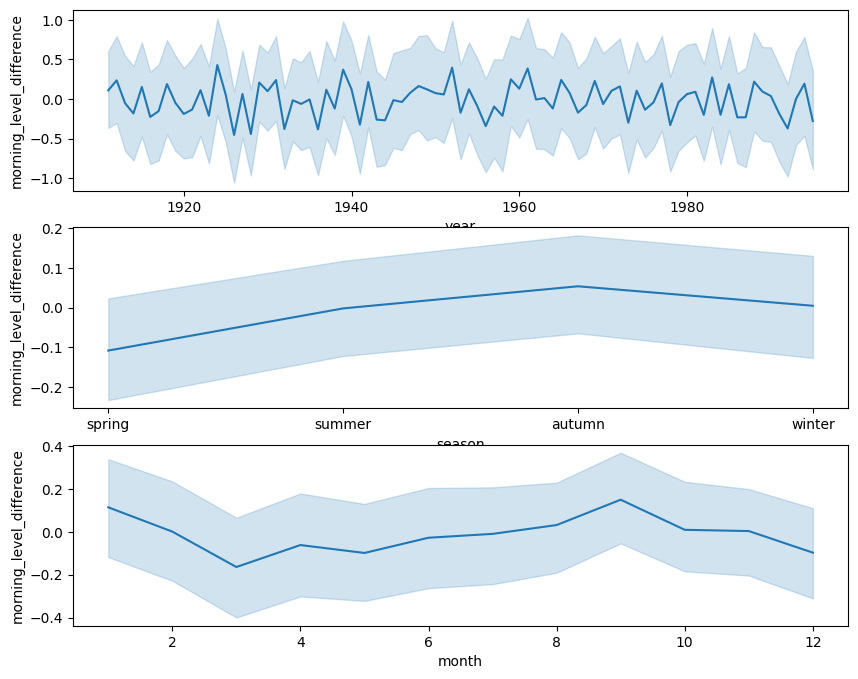

In [39]:
fig,ax = plt.subplots(3,1, figsize = (10,8))

sns.lineplot(data = temp, y = 'morning_level_difference', x  = 'year', ax = ax[0])
sns.lineplot(data = temp, y = 'morning_level_difference', x  = 'season', ax = ax[1])
sns.lineplot(data = temp, y = 'morning_level_difference', x  = 'month', ax = ax[2])

<AxesSubplot: xlabel='month', ylabel='water_level'>

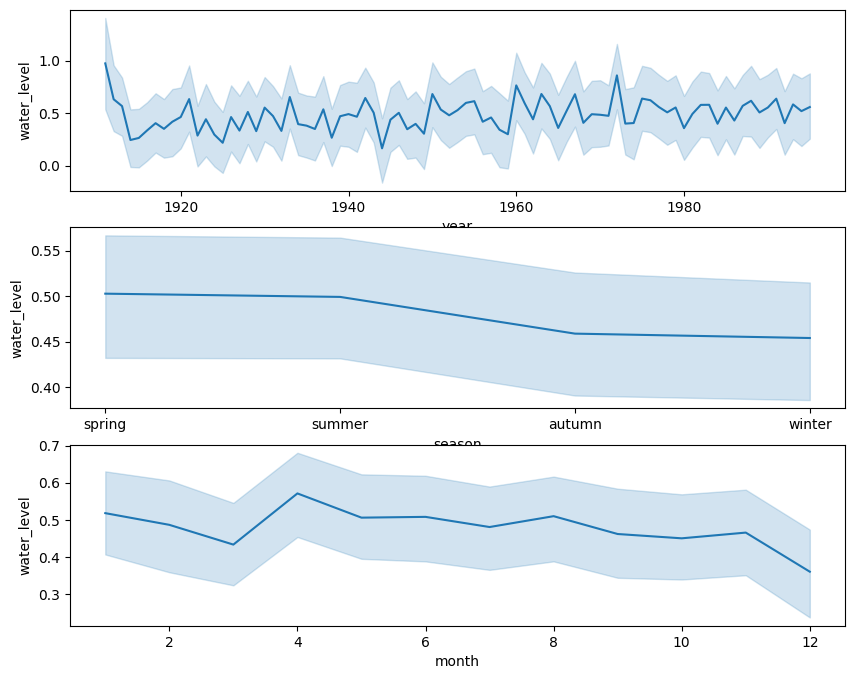

In [202]:
temp_2 = afternoon_levels_df.sample(False, 0.5, 42).toPandas()

fig,ax = plt.subplots(3,1, figsize = (10,8))

sns.lineplot(data = temp_2, y = 'water_level', x  = 'year', ax = ax[0])
sns.lineplot(data = temp_2, y = 'water_level', x  = 'season', ax = ax[1])
sns.lineplot(data = temp_2, y = 'water_level', x  = 'month', ax = ax[2])

<AxesSubplot: >

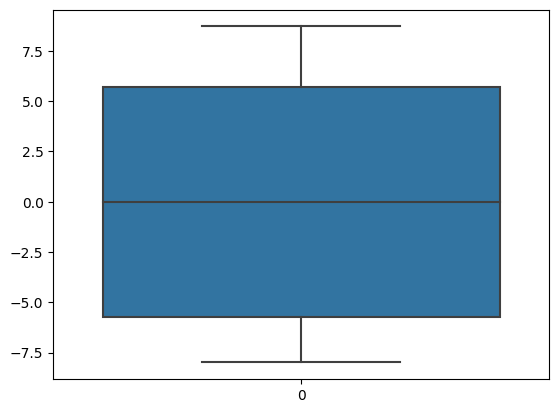

23/01/13 19:50:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1078407 ms exceeds timeout 120000 ms
23/01/13 19:50:45 WARN SparkContext: Killing executors is not supported by current scheduler.


In [42]:
sns.boxplot(temp['morning_level_difference'])

In [137]:
train_df = df.filter(df['year'] < 1970)
test_df = df.filter(df['year'] > 1970)

print(train_df.count()/df.count())
train_df.show()

0.6855925820108568
+-----------+------------+---------+----+-----+------+
|water_level|is_high_tide|Timeofday|year|month|season|
+-----------+------------+---------+----+-----+------+
|      3.713|           1|        1|1911|    5|spring|
|    -2.9415|           0|        0|1911|    5|spring|
|     3.3828|           1|        1|1911|    5|spring|
|    -2.6367|           0|        0|1911|    5|spring|
|     2.9256|           1|        1|1911|    5|spring|
|    -2.4843|           0|        1|1911|    5|spring|
|     3.1542|           1|        1|1911|    5|spring|
|      3.078|           1|        0|1911|    5|spring|
|    -2.4843|           0|        1|1911|    5|spring|
|     2.7732|           1|        0|1911|    5|spring|
|    -1.9509|           0|        1|1911|    5|spring|
|     2.6208|           1|        0|1911|    5|spring|
|    -2.0271|           0|        1|1911|    5|spring|
|     2.6716|           1|        0|1911|    5|spring|
|    -2.1033|           0|        1|1911|    5